In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
pd.options.display.float_format = '{:.2f}'.format
warnings.simplefilter(action='ignore')

In [2]:
def bin_cross_entropy(y, p_hat):
    return -(1/len(y))*np.sum(y*np.log(p_hat) + (1-y) * np.log(1-p_hat))

def accuracy(y, y_hat):
    return np.mean(y == y_hat)

def softmax(h):
    return (np.exp(h.T)/np.sum(np.exp(h), axis = 1)).T

def cross_entropy(y, p_hat):
    return -(1/len(y))*np.sum(np.sum(y*np.log(p_hat), axis = 1), axis = 0)

def OLS(Y,Y_hat):
    return (1/(2*len(Y)))*np.sum((Y-Y_hat)**2)

def indices_one_hot(df, nb_classes):
    targets = np.array(df).reshape(-1)
    return np.eye(nb_classes)[targets]

def one_hot_encode(y):
    N = len(y)
    K = len(set(y))
    
    Y = np.zeros((N,K))
    for i in range(N):
        Y[i, y[i]] = 1
    return Y

In [3]:
def sigmoid(h):
    return 1/(1+np.exp(-h))

def ReLU(H):
    return H*(H>0)

def softmax(H):
    eH = np.exp(H)
    return eH/eH.sum(axis = 1, keepdims = True)

def linear(H):
    return H

def derivatives(Z, a):
    
    ##No parentheses needed to call another function
    if a == linear: 
        return 1
    elif a == sigmoid:
        return Z*(1-Z)
    elif a == ReLU:
        return (Z>0).astype(int)
    elif a == np.tanh:
        return 1-Z*Z
    else:
        ValueError("Unknown Activation Function")

### Loading data

In [6]:
data = pd.read_csv("Final_titanic2.csv")

In [8]:
data.columns

Index(['Pclass_1', 'Pclass_2', 'Pclass_3', 'SmallFamily', 'LargeFamily',
       'Survived', 'AgeGender', 'Alone'],
      dtype='object')

### Split data

In [9]:
train = data.sample(frac = 0.85, replace = True, random_state=43)
test = data.sample(frac = 0.15, replace = True, random_state=45)

### Extracting parameters to scale data

In [10]:
means = train.mean(axis=0)
ranges = train.max(axis=0)-train.min(axis=0)

### Split target and predictors

In [11]:
x_train = train.drop(["Survived"], axis = 1)
y_train = train["Survived"]

x_test = test.drop(["Survived"], axis = 1)
y_test = test["Survived"]

### Getting feats

In [12]:
feats = x_train.columns.values

### Scaling data

In [13]:
x_train_scaled = (x_train - means) / ranges
x_test_scaled = (x_test - means) / ranges

### Casting dataframes to np arrays

In [14]:
x_train = x_train.to_numpy()
x_test = x_test.to_numpy()
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

### Casting scaled data to np arrays

In [15]:
x_train_scaled = x_train_scaled.drop(["Survived"], axis = 1)
y_train = train["Survived"]

x_test_scaled = x_test_scaled.drop(["Survived"], axis = 1)
y_test = test["Survived"]

x_train_scaled = x_train_scaled.to_numpy()
x_test_scaled = x_test_scaled.to_numpy()
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

### Simple Logistic Regression

In [16]:
class SimpleLogReg():
    def __init__(self, thresh = 0.5):
        self.thresh = thresh
        self.W = None
        self.B = None
        
    def fit(self, x, y, eta = 1e-3, epochs = 1e3, show_curve = False):
        epochs = int(epochs)
        N,D = x.shape
        
        #Initialize weights and bias 
        self.W = np.random.randn(D)
        self.B = np.random.randn(1)
        
        J = np.zeros(epochs)
        
        for epoch in range(epochs):
            p_hat = self.__forward__(x)
            J[epoch] = bin_cross_entropy(y, p_hat)
            
            #Weight and Bias updates
            self.W -= eta*(1/N)*x.T@(p_hat-y)
            self.B -= eta*(1/N)*np.sum(p_hat-y)
            
        if show_curve:
            plt.figure()
            plt.plot(J)
            plt.xlabel("epochs")
            plt.ylabel("$\mathcal{J}$")
            plt.title("Training Curve")
            plt.show()
    
    def __forward__(self,x):
        return sigmoid(x@self.W + self.B)
    
    def predict(self, x):
        return (self.__forward__(x) >= self.thresh).astype(np.int32)

### Model unscaled data

In [17]:
log_r = SimpleLogReg()

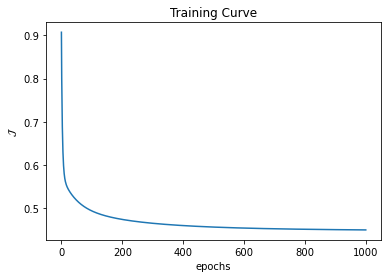

In [18]:
log_r.fit(x_train, y_train, eta = 0.2, epochs = 1000, show_curve = True)

In [19]:
preds = log_r.predict(x_train)

### Training accuracy 

In [20]:
accuracy(preds, y_train)

0.7939233817701453

In [21]:
test_pred = log_r.predict(x_test)

### Test accuracy

In [22]:
accuracy(test_pred, y_test)

0.7611940298507462

### Model Scaled data

In [23]:
log_r_sc = SimpleLogReg()

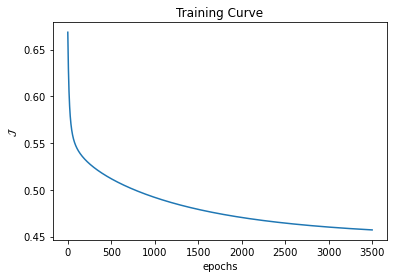

In [24]:
log_r_sc.fit(x_train_scaled, y_train, eta = 0.3, epochs = 3500, show_curve = True)

In [25]:
preds_sc = log_r_sc.predict(x_train_scaled)
accuracy(preds_sc, y_train)

0.7767503302509907

In [26]:
test_pred_sc = log_r_sc.predict(x_test_scaled)
accuracy(test_pred_sc, y_test)

0.7238805970149254

### Neural Network 

In [27]:
class Shallow_ANN():
    
    def fit(self, x, y, neurons = 10, eta = 1e-3, epochs = 1e3, show_curve = False):
        epochs = int(epochs)
        Y = one_hot_encode(y)

        N,D = x.shape
        K = Y.shape[1]

        self.w = {l: np.random.randn(M[0], M[1]) for l,M in enumerate(zip([D,neurons],[neurons,K]),1)}
        self.b = {l: np.random.randn(M) for l, M in enumerate([neurons, K],1)}
        
        self.a = {1:np.tanh, 2:softmax}
        
        J = np.zeros(epochs)
        
        for epoch in range(epochs):
            self.__forward__(x)
            J[epoch] = cross_entropy(Y, self.Z[2])
        
            #Weight update rule
            self.w[2] -= eta*(1/N)*self.Z[1].T@(self.Z[2] - Y)
            self.w[1] -= eta*(1/N)*x.T@((self.Z[2] - Y)@self.w[2].T*(1-self.Z[1]**2))

            #Bias update rule
            self.b[2] -= eta*(1/N)*(self.Z[2]-Y).sum(axis=0)
            self.b[1] -= eta*(1/N)*((self.Z[2]-Y)@self.w[2].T*(1-self.Z[1]**2)).sum(axis=0)
        
        if show_curve:
            plt.figure()
            plt.plot(J)
            plt.xlabel("epochs")
            plt.ylabel("$\mathcal{J}$")
            plt.title("Training Curve")
            plt.show()
        
    def __forward__(self,x):
        self.Z = {0:x}

        for l in sorted(self.w.keys()):
            self.Z[l] = self.a[l](self.Z[l-1]@self.w[l] + self.b[l])

    def predict(self, x):
        self.__forward__(x)
        return self.Z[2].argmax(axis = 1)

In [28]:
ann = Shallow_ANN()

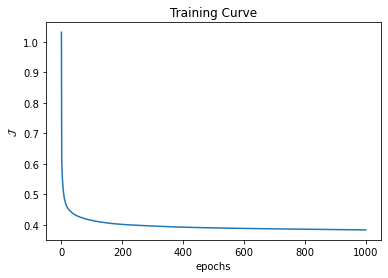

In [29]:
ann.fit(x_train, y_train, eta = 0.35, epochs = 1000, show_curve = True)

In [30]:
ann_preds = ann.predict(x_train)

In [31]:
accuracy(ann_preds, y_train)

0.8309114927344782

### Test predictions

In [32]:
ann_test_pred = ann.predict(x_test)
accuracy(ann_test_pred, y_test)

0.7835820895522388

### Neural Network Scaled

In [33]:
ann_scaled = Shallow_ANN()

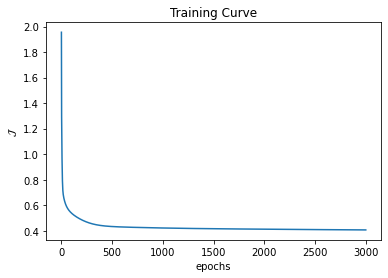

In [34]:
ann_scaled.fit(x_train_scaled, y_train, eta = 0.2, epochs = 3000, show_curve = True)

In [35]:
ann_scaled_preds = ann_scaled.predict(x_train_scaled)
accuracy(ann_scaled_preds, y_train)

0.821664464993395

In [36]:
ann_scaled_test_pred = ann_scaled.predict(x_test_scaled)
accuracy(ann_scaled_test_pred, y_test)

0.7910447761194029

### Variable architecture Neural Network

In [37]:
class ANN():
    
    def __init__(self, architecture, activations = None, mode = 0):
        self.mode = mode
        self.architecture = architecture
        self.activations = activations
        self.L = len(architecture) + 1
    
    
    def fit(self, x, y, eta = 1e-3, epochs = 1000, show_curve = False):
        epochs = int(epochs)
        if self.mode: Y = y
        else: Y = one_hot_encode(y)
        N,D = x.shape
        K = Y.shape[1]
        
        #Initialize Weights and Biases
        self.W = {l: np.random.randn(M[0],M[1]) for l,M in
                 enumerate(zip(([D] + self.architecture), (self.architecture + [K])),1)}
        self.b = {l: np.random.randn(M) for l, M in enumerate(self.architecture + [K], 1)}
        
        #Activation Function Loading
        if self.activations is None:
            self.a = {l: ReLU for l in range(1,self.L)}
        else:
            self.a = {l:act for l,act in enumerate(self.activations,1)}
        
        #Set Mode
        if self.mode: 
            self.a[self.L] = linear
        else: 
            self.a[self.L] = softmax
        
        J = np.zeros(epochs)
        
        for epoch in range(epochs):
            
            self.__forward__(x)
            
            if self.mode:
                J[epoch] = OLS(Y, self.Z[self.L])
            else:
                J[epoch] = cross_entropy(Y, self.Z[self.L])
                
            dH = (1/N) * (self.Z[self.L]-Y)
            
            for l in sorted(self.W.keys(), reverse = True):
                dW = self.Z[l-1].T@dH
                dB = dH.sum(axis = 0)
                
                #Weight and bias update rule
                self.W[l] -= eta * dW
                self.b[l] -= eta * dB
                
                if l > 1:
                    dZ = dH@self.W[l].T
                    dH = dZ * derivatives(self.Z[l-1], self.a[l-1])
                
        if show_curve:
            plt.figure()
            plt.plot(J)
            plt.xlabel("epochs")
            plt.ylabel("$\mathcal{J}$")
            plt.title("Training Curve")
            plt.show()

    def __forward__(self,x):
        self.Z = {0:x}

        for l in sorted(self.W.keys()):
            self.Z[l] = self.a[l](self.Z[l-1]@self.W[l] + self.b[l])

    def predict(self, x):
        self.__forward__(x)

        if self.mode: return self.Z[self.L]
        else: return self.Z[self.L].argmax(axis = 1)

In [38]:
var_ann = ANN([6,8,6], [ReLU, ReLU, ReLU])

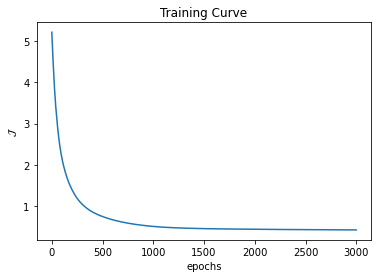

In [39]:
var_ann.fit(x_train, y_train, eta = 0.001, epochs = 3000, show_curve=True) 

In [40]:
var_preds = var_ann.predict(x_train)
accuracy(var_preds, y_train)

0.809775429326288

In [41]:
vann_test_pred = var_ann.predict(x_test)
accuracy(vann_test_pred, y_test)

0.7835820895522388

### Variable architecture Neural Network Scaled

In [42]:
var_ann_scaled = ANN([6,8,8,6], [ReLU, ReLU, ReLU, ReLU])

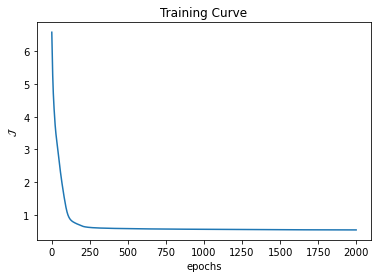

In [43]:
var_ann_scaled.fit(x_train_scaled, y_train, eta = 0.001, epochs = 2000, show_curve=True) 

In [44]:
var_preds_scaled = var_ann_scaled.predict(x_train_scaled)
accuracy(var_preds_scaled, y_train)

0.7820343461030383

In [45]:
vann_s_test_pred = var_ann_scaled.predict(x_test_scaled)
accuracy(vann_s_test_pred, y_test)

0.8134328358208955

In [49]:
actual = pd.Series(y_test.tolist(), name = "Actual")
prediction = pd.Series(vann_s_test_pred.tolist(), name = "Predicted")
matrix = pd.crosstab(actual,prediction)

In [50]:
matrix["Total"] = matrix.sum(axis = 1)
c = 0
error = []
for i in range(len(matrix)):
    n = (((matrix[i][c] / matrix["Total"][c])))*100
    error.append(round(n,2))
    c += 1
matrix["Pred %"] = error
matrix

Predicted,0,1,Total,Pred %
Actual,,,,
0,68,9,77,88.31
1,16,41,57,71.93


In [51]:
acc = pd.DataFrame({"Logistic Regresion": [accuracy(test_pred_sc, y_test)], 
    "Logistic Regresion Scaled": [accuracy(test_pred_sc, y_test)],
    "Neural Network": [accuracy(ann_test_pred, y_test)],
    "Neural Network Scaled": [accuracy(ann_scaled_test_pred, y_test)],
    "VA Neural Network": [accuracy(vann_test_pred, y_test)],
    "VA Neural Network Scaled": [accuracy(vann_s_test_pred, y_test)]}, 
     index = {"Accuracy":0})

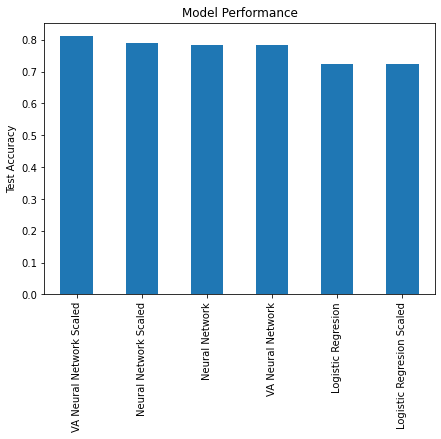

In [52]:
acc.iloc[0].sort_values(ascending = False).plot.bar(figsize = (7,5))
plt.ylabel("Test Accuracy")
plt.title("Model Performance")
plt.show()

In [53]:
feats

array(['Pclass_1', 'Pclass_2', 'Pclass_3', 'SmallFamily', 'LargeFamily',
       'AgeGender', 'Alone'], dtype=object)